In [7]:
import xarray as xr
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
#import xrft
import matplotlib.pyplot as plt
#import pandas as pd
from tqdm import tqdm
import os
import glob
from pathlib import Path
from typing import Union, List
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch.nn.functional as F
import cartopy.crs as ccrs
import pickle

In [8]:
from src.utils import load_ssf_acoustic_variables, load_sound_speed_fields
from src.data import TrainingItem, AutoEncoderDatamodule
from src.acoustic_predictor import ConvBlock, AcousticPredictor
from src.autoencoder import AutoEncoder

In [9]:

sound_speed_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ecs_path = "/DATASET/eNATL/eNATL60_BLB002_cutoff_freq_regrid_0_1000m.nc"

In [10]:
ss_da = xr.open_dataarray(sound_speed_path)
ecs_da = xr.open_dataset(ecs_path)['ecs']

In [12]:
ae_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_4_relu_lr_0.001"
model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[0]
arch_shape = '_'.join(ae_path.split('/')[-1].split('_')[:2])

model_ap_path= "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/"
model_ap_path = glob.glob(f"{model_ap_path}/**/*.ckpt",recursive=True)[0]
acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path, input_depth= 107)


In [14]:
with open(pickle_ae_path, 'rb') as file:
    time_idx_split = pickle.load(file)

ss_da_test = ss_da.sel(time=time_idx_split['test'])
ecs_da_test = ecs_da.sel(time=time_idx_split['test'])
coords = ss_da_test.coords

In [15]:
y_min_axs = -20
y_max_axs = 1020
x_min_axs = 1450
x_max_axs = 1550

coords = ss_da.coords

In [16]:
plt.style.use('ggplot')

# Functions

## load datamodule

In [17]:

def init_ae(model_ae_path:str,  
            sound_speed_path:str,
            ecs_path:Union[str, None] = None,
            gpu:Union[int,None]= None,
            verbose:float = True):
    
    
    if torch.cuda.is_available() and gpu is not None:
    ##This may not be necessary outside the notebook
        dev = f"cuda:{gpu}"
    else:
        dev = "cpu"

    device = torch.device(dev)

    if verbose:
        print("Selected device:", device)


    if model_ae_path[-5:] == ".ckpt":
        pass

    elif os.path.isdir(model_ae_path):
        model_ae_path = glob.glob(os.path.join(model_ae_path, "**/*.ckpt"), recursive=True)[0]

    else:
        raise ValueError("model_ae_path should leads towards a chekpoint file (.ckpt) or toward a directory containing one checkpoint file. Research in sub_directories is allowed but only the chekpoint file found first is retrieved")

    ap_indicator, arch_shape =  model_ae_path.split("/")[-4:-2]

    
    if verbose:
        print("Selected AutoEncoder model:", model_ae_path)

    if ap_indicator == "AE_with_AP" : 

        if ecs_path is None:
            raise ValueError("For models using acoustic predictor, ecs_path should be defined")
        
        
        input_da = load_ssf_acoustic_variables(sound_speed_path, ecs_path) 
        
        #* By default the first chekpoint is selected
        
    else:
        model_ap_path = None
        input_da = load_sound_speed_fields(sound_speed_path)  
        
    if verbose:
        print("Selected Accoustic Predictor model:", str(model_ap_path)) 
        print("Loading celerity data")
    
    return input_da, ap_indicator, arch_shape, device

In [18]:
def load_datamodule(input_da: xr.Dataset,
                    ap_indicator: str,
                    device: str,
                    x_min: Union[float, None] = None,
                    x_max: Union[float, None] = None,
                    phases: Union[str, List[str]] = ["train", "val", "test"],
                    domains: dict = dict(
                        train = dict(time = slice(0, 254, None)),
                        val = dict(time = slice(254, 331, None)),
                        test = dict(time = slice(331, 365, None))
                        ),
                    verbose:float = True
                    ):
    
    
    if isinstance(phases, str):
        phases = list(phases)
    
    elif isinstance(phases, list):
        pass
    
    else: 
        raise ValueError("Argument phases should be a string or a list of strings")
    
    dm_dict = dict()
    
    stage = dict(train = "fit",
            val = "fit",
            test = "test"
            )
    

    for phase in tqdm(phases, unit = "phase", desc = "Treating splited phases"):
        
        if verbose:
            print("phase:", phase)

        dl_kw = {
            'batch_size': domains[phase]['time'].stop - domains[phase]['time'].start, 
            'num_workers': 1
            }

        #coords = input_da.isel(domains[phase]).coords

        if verbose:
            print("\tGenerating dataloader")

        if ap_indicator == "AE_with_AP":
            dm = BaseDatamodule(input_da, domains, dl_kw, x_min=x_min, x_max =x_max)
            ###TODO: Gérer cette partie
            
        else:
            dm = AutoEncoderDatamodule(input_da, domains, dl_kw, x_min=x_min, x_max =x_max)
            
        dm.setup(stage = stage[phase])

        if phase == "train":
            dataloader = dm.train_dataloader()
            
        elif phase == "val":
            dataloader = dm.val_dataloader()
            
        elif phase == "test":
            dataloader = dm.test_dataloader()
            
        else: 
            raise ValueError("phase in phases should be train, val or test")
        
        
        if len(dataloader) != 1:
            raise ValueError("Dataloader should only contain 1 batch. This should never be seen for debugging purpose only")

            

        batch = next(iter(dataloader))
        x, y = batch
        
        
        if ap_indicator == "AE_with_AP":
            dm_dict[phase] = (x.to(device),y.to(device))
        
        else:
            dm_dict[phase] = x.to(device)
        
        
    return dm_dict



## ECS

In [19]:
def reduce_profile(z_w, sos_w):
    """
    Reduce a profile by finding min-max singular points (linear reduction)

    Parameters
    ----------
    z_w : Float array
        depth values (in m > 0).
    sos_w : Float array
        sound velocities along z_w (in m/s).

    Comment
    -------
    Assumption is made by the profile is regular (starts at surface and stop at
    bottom). None or nan value need to be dealt with before the reduction

    Returns
    -------
    z_w_red : Float array
        Singular point depth values.
    sos_w_red : Float array
        Singular point sound speed values.

    """
    # compute the sign of consecutive points differences, then, search where
    # change occurs by differencing again and finding where results equal 2.
    ind = np.where(abs(np.diff(np.sign(np.diff(sos_w)))) == 2)
    # compensation for loosing one in index dimension due to differencation
    ind += np.ones((len(ind)))

    sos_w_red = sos_w[[int(i) for i in ind[0]]]
    z_w_red = z_w[[int(i) for i in ind[0]]]

    # insert surface point and bottom point
    sos_w_red = np.insert(sos_w_red, 0, sos_w[0])
    z_w_red = np.insert(z_w_red, 0, 0)
    sos_w_red = np.insert(sos_w_red, len(sos_w_red), sos_w[-1])
    z_w_red = np.insert(z_w_red, len(z_w_red), z_w[-1])

    return z_w_red, sos_w_red

# get profiles of interrest

In [53]:
depth_std = torch.tensor(ss_da_test.data.std(axis=1))

flatten_max_std_idx = torch.topk(depth_std.nan_to_num(0).flatten(), k = 4).indices
max_ss_std_idx = torch.stack(torch.unravel_index(flatten_max_std_idx, depth_std.shape),dim=1)
flatten_min_std_idx = torch.topk(depth_std.nan_to_num(1e5).flatten(), k = 4, largest = False).indices
min_ss_std_idx = torch.stack(torch.unravel_index(flatten_min_std_idx, depth_std.shape),dim=1)



depth_std_150m = torch.tensor(ss_da_test.where(ss_da_test.z<=150, drop=True).data.std(axis=1))

flatten_max_std_150_idx = torch.topk(depth_std_150m.nan_to_num(0).flatten(), k = 4).indices
max_ss_std_150_idx = torch.stack(torch.unravel_index(flatten_max_std_150_idx, depth_std.shape),dim=1)
flatten_min_std_150_idx = torch.topk(depth_std_150m.nan_to_num(1e5).flatten(), k = 4, largest = False).indices
min_ss_std_150_idx = torch.stack(torch.unravel_index(flatten_min_std_150_idx, depth_std.shape),dim=1)

In [54]:
del depth_std 
del depth_std_150m
del flatten_max_std_idx
del flatten_max_std_150_idx
del flatten_min_std_150_idx

In [55]:
sorted_ecs_idx = np.argsort(ecs_da.values,axis=None)  
max_ecs_idx = np.stack(np.unravel_index(sorted_ecs_idx[-4:], ecs_da.shape),axis=1)
min_ecs_idx = np.stack(np.unravel_index(sorted_ecs_idx[:4], ecs_da.shape),axis=1)


In [56]:
del sorted_ecs_idx

In [57]:
nan_idx = np.argwhere(np.isnan(ss_da_test.data))
nan_idx[:, 0], nan_idx[:, 1] = nan_idx[:, 1].copy(), nan_idx[:, 0].copy()
nan_index_time_lat_lon, nan_counts = np.unique(nan_idx[:, -3:], axis=0, return_counts=True)
nan_index_time_lat_lon = np.column_stack((nan_index_time_lat_lon, nan_counts))
nan_index_time_lat_lon = nan_index_time_lat_lon[np.argsort(nan_index_time_lat_lon[:,-1])]

nan_max = nan_index_time_lat_lon[-1,-1]
nan_index_lat_lon_repartition = np.stack([nan_index_time_lat_lon[0],
                                          nan_index_time_lat_lon[np.searchsorted(nan_index_time_lat_lon[:,-1], nan_max // 4)],
                                          nan_index_time_lat_lon[np.searchsorted(nan_index_time_lat_lon[:,-1], nan_max // 2)],
                                          nan_index_time_lat_lon[np.searchsorted(nan_index_time_lat_lon[:,-1], 3* nan_max // 4)],
                                          nan_index_time_lat_lon[-1]],
                                         axis=0)

In [58]:
del nan_idx
del nan_index_time_lat_lon
del nan_counts

In [59]:
time_lon_idx = np.unravel_index(ss_da_test.std(dim=('z','lat')).argmax().item(), (len(coords['time']),len(coords['lon'])))
time_lat_idx = np.unravel_index(ss_da_test.std(dim=('z','lon')).argmax().item(), (len(coords['time']),len(coords['lat'])))

max_std_lat=np.column_stack((np.full_like(np.arange(240), time_lon_idx[0]), np.arange(240), np.full_like(np.arange(240), time_lon_idx[1])))
max_std_lon=np.column_stack((np.full_like(np.arange(240), time_lat_idx[0]), np.arange(240), np.full_#for n_components in range(5):like(np.arange(240), time_lat_idx[1])))

In [60]:
n = 1000
sizes = [len(coords['time']), len(coords['lat']), len(coords['lon'])]
random_t_lat_lon = np.array([np.random.randint(0, size, size=(n)) for size in sizes]).T

In [61]:
profile_idx_dict = dict(
    min_std=min_ss_std_idx,
    max_std=max_ss_std_idx,
    min_std_150=min_ss_std_150_idx,
    max_std_150=max_ss_std_150_idx,
    min_ecs=min_ecs_idx,
    max_ecs=max_ecs_idx,
    nan_profile_idx=nan_index_lat_lon_repartition[:-1,:-1],
    max_std_lat=max_std_lat,
    max_std_lon=max_std_lon,
    random_1000=random_t_lat_lon   
    
)

profile_idx_dict

{'min_std': tensor([[ 17, 112,  24],
         [ 17, 111,  25],
         [ 17, 113,  23],
         [ 17, 113,  22]]),
 'max_std': tensor([[ 22, 122,   1],
         [ 22, 122,   2],
         [ 22, 123,   2],
         [ 22, 123,   3]]),
 'min_std_150': tensor([[ 12, 152, 216],
         [ 16, 170,  12],
         [ 23,  59, 216],
         [ 23,  59, 215]]),
 'max_std_150': tensor([[ 14, 214,  42],
         [ 14, 214,  43],
         [ 14, 213,  43],
         [ 14, 212,  44]]),
 'min_ecs': array([[27, 87, 80],
        [50, 36, 36],
        [50, 36, 35],
        [50, 36, 34]]),
 'max_ecs': array([[289,  75, 125],
        [288,  76, 126],
        [288,  76, 128],
        [298,  71, 120]]),
 'nan_profile_idx': array([[  6, 228, 119],
        [  3, 218,  86],
        [ 30, 200,   6],
        [  0, 219,  20]]),
 'max_std_lat': array([[ 21,   0,  17],
        [ 21,   1,  17],
        [ 21,   2,  17],
        [ 21,   3,  17],
        [ 21,   4,  17],
        [ 21,   5,  17],
        [ 21,   6,  17],

# PCA

# Load datamodule

In [20]:


x_min = 1459.0439165829073
x_max = 1545.8698054910844
verbose = True
gpu = None

domains = dict(
    train = dict(time = slice(0, 254, None)),
    val = dict(time = slice(254, 331, None)),
    test = dict(time = slice(331, 365, None))
    )


In [27]:
ae_path_dict = {
    "4_4_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_4_relu_lr_0.001",
    "16_60_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/16_60_relu_lr_0.001",
    "pca_4_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/pca_4_relu_lr_0.001",
    "4_15_test_without_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_15_test_relu_lr_0.001",
    "4_4_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/4_4_relu_lr_0.001",
    "16_60_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/16_60_relu_lr_0.001",
    "pca_4_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/pca_4_relu_lr_0.001",
    "4_15_test_with_AP":"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_with_AP/4_15_test_relu_lr_0.001",
    }

output_ae_test_dict = {}

time_idx = []

ae_path = list(ae_path_dict.values())[0]
model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[0]


    

    

input_da, ap_indicator, arch_shape, device = init_ae(model_ae_path,  
                                                    sound_speed_path,
                                                    gpu = 0)

dm = load_datamodule(input_da,
                    ap_indicator,
                    device,
                    x_min,
                    x_max
                    )



x_train = dm['train']
input_train_shape = x_train.shape


x_test = dm['test']
input_test_shape = x_test.shape

print("\n normalization values")
print("x test min", x_test.min())
print("x test max",x_test.max())

 
for arch_shape,ae_path in ae_path_dict.items():
    arch_shape_struct = '_'.join(arch_shape.split('_')[:-2])
    print(f"\n architecture: {arch_shape}")
    model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
    pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle",recursive=True)[0]
    
    model_ae = AutoEncoder.load_from_checkpoint(model_ae_path,x_min = x_min, x_max = x_max, acoustic_predictor= acoustic_predictor, arch_shape = arch_shape_struct).to(device)
    output_ae_test = model_ae(x_test.to(device)).cpu().detach().numpy()* (x_max - x_min)+ x_min
    
    output_ae_test_dict[arch_shape] = output_ae_test
    
    
    print("min value", model_ae(x_test.to(device)).cpu().detach().numpy().min())
    print("max value",model_ae(x_test.to(device)).cpu().detach().numpy().max())
    







Selected device: cuda:0
Selected AutoEncoder model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_4_relu_lr_0.001/2024-03-25_18-00/checkpoints/val_loss=0.13-epoch=963.ckpt
Selected Accoustic Predictor model: None
Loading celerity data


Treating splited phases:   0%|          | 0/3 [00:00<?, ?phase/s]

phase: train
	Generating dataloader


Treating splited phases:  33%|███▎      | 1/3 [00:35<01:10, 35.26s/phase]

phase: val
	Generating dataloader


Treating splited phases:  67%|██████▋   | 2/3 [01:10<00:35, 35.22s/phase]

phase: test
	Generating dataloader


Treating splited phases: 100%|██████████| 3/3 [01:19<00:00, 26.57s/phase]



 normalization values
x test min tensor(0., device='cuda:0')
x test max tensor(0.9897, device='cuda:0')

 architecture: 4_4_without_AP
min value 0.46276736
max value 0.77761227
['2009-12-22T12:00:00.000000000' '2010-01-06T12:00:00.000000000'
 '2010-06-28T12:00:00.000000000' '2010-01-04T12:00:00.000000000'
 '2009-12-17T12:00:00.000000000'] ... ['2009-09-10T12:00:00.000000000' '2009-10-15T12:00:00.000000000'
 '2010-03-28T12:00:00.000000000' '2010-06-14T12:00:00.000000000'
 '2009-10-11T12:00:00.000000000']

 architecture: 16_60_without_AP
min value 0.0
max value 0.9996184
['2009-12-22T12:00:00.000000000' '2010-01-06T12:00:00.000000000'
 '2010-06-28T12:00:00.000000000' '2010-01-04T12:00:00.000000000'
 '2009-12-17T12:00:00.000000000'] ... ['2009-09-10T12:00:00.000000000' '2009-10-15T12:00:00.000000000'
 '2010-03-28T12:00:00.000000000' '2010-06-14T12:00:00.000000000'
 '2009-10-11T12:00:00.000000000']

 architecture: pca_4_without_AP
min value 6.7896167e-06
max value 0.763914
['2009-12-22T12

In [ ]:
###* test
for arch_shape,ae_path in ae_path_dict.items():
    arch_shape_struct = '_'.join(arch_shape.split('_')[:-2])
    print(f"\n architecture: {arch_shape}")
    model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt",recursive=True)[0]
    
    with open(pickle_ae_path, 'rb') as file:
        time_idx_split = pickle.load(file)
    time_idx.append(time_idx_split['test'])
    print(time_idx_split['test'][:5],'...',time_idx_split['test'][-5:])

In [30]:
time_idx[0]

array(['2009-12-22T12:00:00.000000000', '2010-01-06T12:00:00.000000000',
       '2010-06-28T12:00:00.000000000', '2010-01-04T12:00:00.000000000',
       '2009-12-17T12:00:00.000000000', '2009-08-28T12:00:00.000000000',
       '2009-08-18T12:00:00.000000000', '2010-02-21T12:00:00.000000000',
       '2010-03-10T12:00:00.000000000', '2009-07-22T12:00:00.000000000',
       '2010-05-10T12:00:00.000000000', '2009-12-08T12:00:00.000000000',
       '2010-04-03T12:00:00.000000000', '2010-01-08T12:00:00.000000000',
       '2010-04-20T12:00:00.000000000', '2010-06-09T12:00:00.000000000',
       '2010-03-15T12:00:00.000000000', '2010-05-05T12:00:00.000000000',
       '2009-11-27T12:00:00.000000000', '2009-11-08T12:00:00.000000000',
       '2009-11-29T12:00:00.000000000', '2009-10-08T12:00:00.000000000',
       '2009-09-26T12:00:00.000000000', '2010-05-27T12:00:00.000000000',
       '2010-01-31T12:00:00.000000000', '2009-10-30T12:00:00.000000000',
       '2010-06-30T12:00:00.000000000', '2009-07-21

In [29]:
(ss_da.isel(time=time_idx[-1]).time == time_idx[0]).all()

<xarray.DataArray 'time' (time: 36)>
array(['2009-11-14T12:00:00.000000000', '2010-04-18T12:00:00.000000000',
       '2010-05-14T12:00:00.000000000', '2009-10-16T12:00:00.000000000',
       '2009-10-13T12:00:00.000000000', '2009-08-23T12:00:00.000000000',
       '2009-09-11T12:00:00.000000000', '2009-09-15T12:00:00.000000000',
       '2010-06-13T12:00:00.000000000', '2010-02-14T12:00:00.000000000',
       '2009-09-04T12:00:00.000000000', '2010-05-03T12:00:00.000000000',
       '2010-03-20T12:00:00.000000000', '2010-04-30T12:00:00.000000000',
       '2009-07-10T12:00:00.000000000', '2010-06-20T12:00:00.000000000',
       '2010-04-21T12:00:00.000000000', '2010-06-22T12:00:00.000000000',
       '2010-05-31T12:00:00.000000000', '2010-06-21T12:00:00.000000000',
       '2009-08-20T12:00:00.000000000', '2010-06-09T12:00:00.000000000',
       '2009-09-25T12:00:00.000000000', '2009-07-14T12:00:00.000000000',
       '2010-06-07T12:00:00.000000000', '2010-06-24T12:00:00.000000000',
       '2009-07-26T12:00:00.000000000', '2009-10-30T12:00:00.000000000',
       '2009-12-19T12:00:00.000000000', '2010-01-24T12:00:00.000000000',
       '2009-12-24T12:00:00.000000000', '2010-06-10T12:00:00.000000000',
       '2010-05-01T12:00:00.000000000', '2010-05-21T12:00:00.000000000',
       '2010-01-16T12:00:00.000000000', '2010-06-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-11-14T12:00:00 ... 2010-06-01T12:00:00
Attributes:
    time_origin:  1900-01-01 00:00:00
    title:        Time
    long_name:    Time axis

In [143]:
ecs_from_ae_rmse_dict = {}

for arch_shape,output_ae_test in output_ae_test_dict.items():
    ecs_list = []
    ecs_truth_list = ecs_da_test.isel(time=random_t_lat_lon[:,0], lat = random_t_lat_lon[:,1], lon = random_t_lat_lon[:,2]).data

    for i in range(len(random_t_lat_lon)):
        ecs_list.append(reduce_profile(coords['z'].values, output_ae_test[random_t_lat_lon[i][0],:,random_t_lat_lon[i][1],random_t_lat_lon[i][2]])[0][1])
        
    ecs_from_ae_rmse_dict[arch_shape] = np.sqrt(np.mean((ecs_truth_list - np.array(ecs_list))**2))
    

In [165]:

print(model_ae(x_test.to(device)).cpu().detach().numpy().min())
print(model_ae(x_test.to(device)).cpu().detach().numpy().max())

tensor(0., device='cuda:0')
tensor(0.9777, device='cuda:0')
0.11763957
0.7502994


In [26]:
time_idx[-2]

[136,
 291,
 317,
 107,
 104,
 53,
 72,
 76,
 347,
 228,
 65,
 306,
 262,
 303,
 9,
 354,
 294,
 356,
 334,
 355,
 50,
 343,
 86,
 13,
 341,
 358,
 25,
 121,
 171,
 207,
 176,
 344,
 304,
 324,
 199,
 335]

## PCA over depth

In [66]:

input_train_depth_feature = x_train.reshape(-1,input_train_shape[-1]).to('cpu')
input_test_depth_feature = x_test.reshape(-1,input_test_shape[-1]).to('cpu')


In [168]:
n_components = 107
pca = PCA(n_components = n_components)
pca.fit(input_train_depth_feature)
output_test_decoded_pca = pca.inverse_transform(pca.transform(input_test_depth_feature)).reshape(input_test_shape)
output_test_decoded_pca = output_test_decoded_pca*(x_max - x_min)+ x_min

ecs_list = []
ecs_truth_list = []
for i in range(len(random_t_lat_lon)):
    ecs_truth_list.append(ecs_da_test.isel(time=random_t_lat_lon[i][0], lat = random_t_lat_lon[i][1], lon = random_t_lat_lon[i][2]).data)
    ecs_list.append(reduce_profile(coords['z'].values, output_test_decoded_pca[random_t_lat_lon[i][0],:,random_t_lat_lon[i][1],random_t_lat_lon[i][2]])[0][1])


rmse_dict[n_components]=np.sqrt(np.mean((np.array(ecs_truth_list) - np.array(ecs_list))**2))

In [171]:
output_test_decoded_pca

array([[[[1541.57260065, 1541.74741838, 1541.93576131, ...,
          1541.26628239, 1541.21254185, 1541.14489801],
         [1541.46954852, 1541.65330023, 1541.84681115, ...,
          1541.2707945 , 1541.22273744, 1541.15871812],
         [1541.31407437, 1541.46759689, 1541.62046139, ...,
          1541.28128993, 1541.2376707 , 1541.17628575],
         ...,
         [1459.03835375, 1459.04363093, 1459.06657771, ...,
          1509.90947622, 1510.54677153, 1510.97230322],
         [1459.03659544, 1459.04539553, 1459.06536257, ...,
          1510.06402396, 1510.49699784, 1510.78518118],
         [1459.0394162 , 1459.04405289, 1459.05987055, ...,
          1510.59380381, 1510.77970332, 1510.84008571]],

        [[1541.2758606 , 1541.43444334, 1541.60659073, ...,
          1541.29167188, 1541.23805082, 1541.16998546],
         [1541.2021273 , 1541.36571753, 1541.54008381, ...,
          1541.29658678, 1541.24870602, 1541.18428436],
         [1541.08463952, 1541.22171039, 1541.35415079, .

### Get RMSE per components

In [114]:
rmse_dict = {}

for n_components in range(len(coords['z'])):
    
    pca = PCA(n_components = n_components)
    pca.fit(input_train_depth_feature)
    output_test_decoded_pca = pca.inverse_transform(pca.transform(input_test_depth_feature)).reshape(input_test_shape)
    output_test_decoded_pca = output_test_decoded_pca*(x_max - x_min)+ x_min

    ecs_list = []
    ecs_truth_list = []
    for i in range(len(random_t_lat_lon)):
        ecs_truth_list.append(ecs_da_test.isel(time=random_t_lat_lon[i][0], lat = random_t_lat_lon[i][1], lon = random_t_lat_lon[i][2]).data)
        ecs_list.append(reduce_profile(coords['z'].values, output_test_decoded_pca[random_t_lat_lon[i][0],:,random_t_lat_lon[i][1],random_t_lat_lon[i][2]])[0][1])
    

    rmse_dict[n_components]=np.sqrt(np.mean((np.array(ecs_truth_list) - np.array(ecs_list))**2))

KeyboardInterrupt: 

In [115]:
rmse_dict

{0: 910.3827491121721,
 1: 366.180746254905,
 2: 324.91194829564733,
 3: 307.9228766286845,
 4: 298.6099942891335,
 5: 287.48513815739096,
 6: 288.91409961335455,
 7: 280.71720891177586,
 8: 279.60213452045696,
 9: 276.3462440980965,
 10: 268.28980391304276,
 11: 263.5686437956027,
 12: 257.1354326736258,
 13: 253.0851975560574,
 14: 245.55005528578968,
 15: 248.80230358670838,
 16: 253.1207145208317,
 17: 247.88669149503374,
 18: 246.20390927952857,
 19: 240.8393532752337,
 20: 239.6436222019945,
 21: 241.9659307276868,
 22: 237.0704844003942,
 23: 241.7648786688976,
 24: 245.94736775122175,
 25: 244.21933753844164,
 26: 243.98908523217528,
 27: 244.7365979647555,
 28: 242.86903750281562,
 29: 243.10726190858924,
 30: 243.14457376047437,
 31: 244.58498319272064,
 32: 240.8773687029606,
 33: 240.3742246158101,
 34: 236.5482451392146,
 35: 233.3033261869217,
 36: 235.32124934070077,
 37: 238.16341500389714,
 38: 239.45035436395688,
 39: 236.58216217616325,
 40: 233.88135367556677,
 41: 

In [116]:
with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/ecs_pca_rmse_per_components.pkl", "wb") as file:
    pickle.dump(rmse_dict, file)

Text(0.5, 0.95, 'Max std in first 150m celerity profiles')

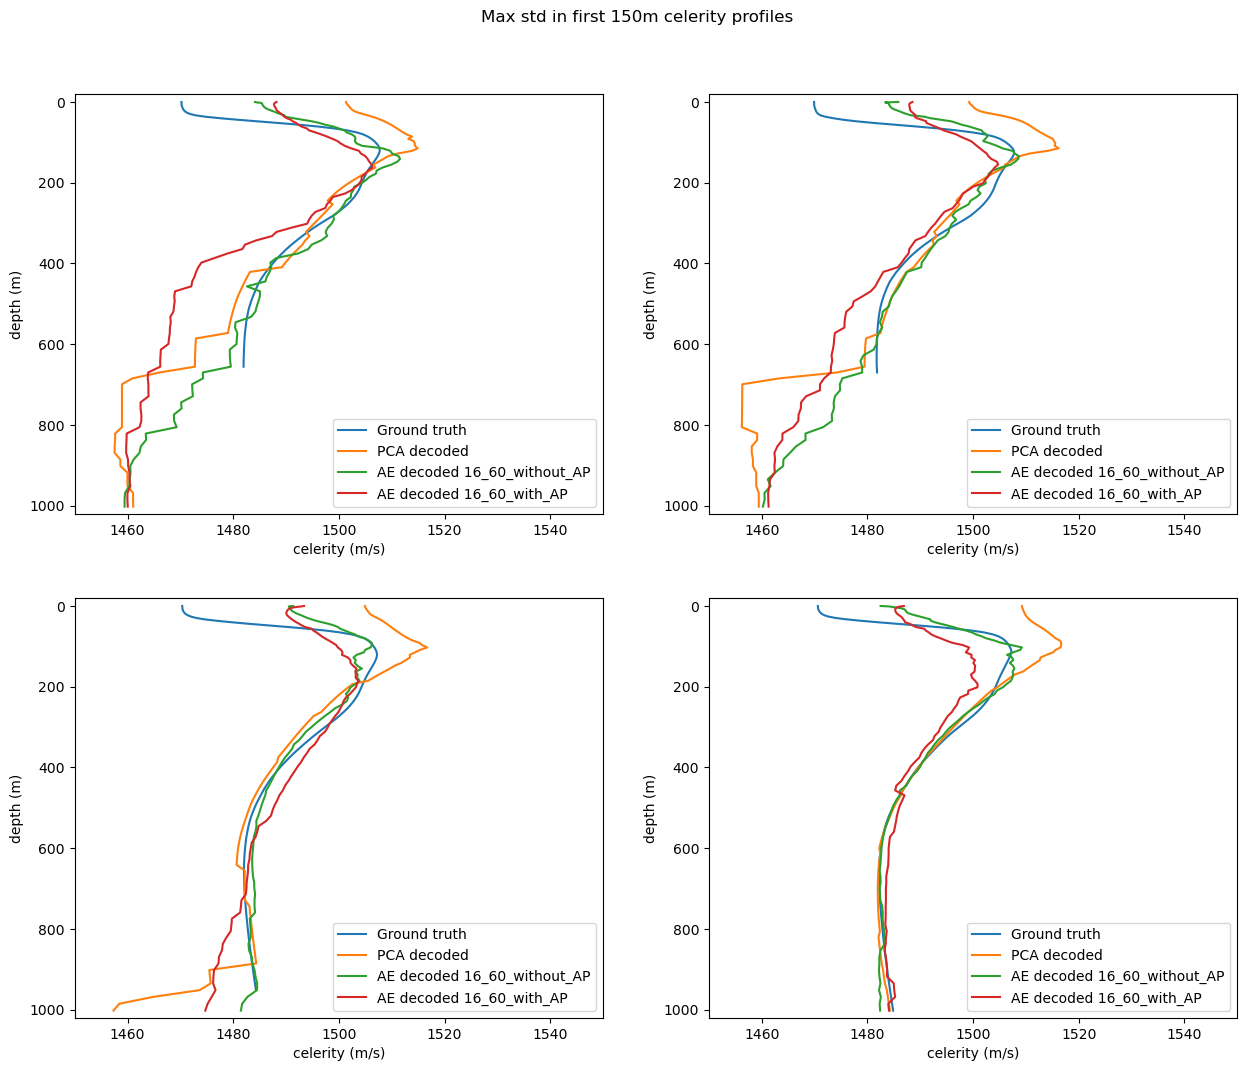

In [147]:
fig,axs = plt.subplots(2,2, figsize = (15,12))
for i,ax in enumerate(axs.flatten()):
    t,lat,lon = min_ss_std_idx[i]
    ax.plot(ss_da_test.isel(time = max_ss_std_150_idx[i][0], lat = max_ss_std_150_idx[i][1], lon = max_ss_std_150_idx[i][2]),coords['z'].values, label = 'Ground truth')
    ax.plot(output_test_decoded_pca[max_ss_std_150_idx[i][0],:,max_ss_std_150_idx[i][1],max_ss_std_150_idx[i][2]],coords['z'].values, label = 'PCA decoded')
    for arch_shape,output_ae_test in output_ae_test_dict.items():
        if '_'.join(arch_shape.split('_')[:-2]) in ['16_60']:
            ax.plot(output_ae_test[max_ss_std_150_idx[i][0],:,max_ss_std_150_idx[i][1],max_ss_std_150_idx[i][2]],coords['z'].values, label = f"AE decoded {arch_shape}")
    ax.set_ylim(y_min_axs, y_max_axs)  # Set y-axis limits
    ax.set_xlim(x_min_axs, x_max_axs)  # Set x-axis limits
    ax.invert_yaxis()
    ax.set_xlabel('celerity (m/s)')
    ax.set_ylabel('depth (m)')
    ax.legend()
title = "Max std in first 150m celerity profiles"
fig.suptitle(title, y = 0.95)

In [159]:
ss_da_test.isel(time = max_ss_std_150_idx[0][0], lat = max_ss_std_150_idx[0][1], lon = max_ss_std_150_idx[0][2])

<xarray.DataArray 'celerity' (z: 107)>
array([1470.190047, 1470.199971, 1470.213068, 1470.201795, 1470.201155,
       1470.213494, 1470.242238, 1470.290441, 1470.349566, 1470.422291,
       1470.520307, 1470.664455, 1470.883797, 1471.218594, 1471.786278,
       1472.82957 , 1474.681236, 1477.393871, 1480.734454, 1484.532748,
       1488.542053, 1492.487036, 1496.056682, 1499.073936, 1501.511569,
       1503.342655, 1504.60288 , 1505.477609, 1506.131947, 1506.66    ,
       1507.100013, 1507.451916, 1507.674838, 1507.721158, 1507.583114,
       1507.322082, 1506.995109, 1506.628977, 1506.246762, 1505.851457,
       1505.479747, 1505.135343, 1504.837702, 1504.561962, 1504.293097,
       1504.040295, 1503.753502, 1503.355589, 1502.888711, 1502.283261,
       1501.611107, 1500.781156, 1499.858864, 1498.855883, 1497.63549 ,
       1496.419327, 1495.233267, 1494.114038, 1493.043959, 1492.012204,
       1491.006786, 1490.071902, 1489.203889, 1488.373224, 1487.600621,
       1486.90583 , 1486.185327, 1485.546226, 1484.972383, 1484.512278,
       1484.10526 , 1483.723352, 1483.375082, 1483.054576, 1482.806581,
       1482.607879, 1482.444366, 1482.326522, 1482.209254, 1482.132271,
       1482.073651, 1482.023853, 1481.989494, 1481.948074, 1481.946654,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan])
Coordinates:
    lon      float64 -63.85
    lat      float64 42.7
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
    time     datetime64[ns] 2010-04-20T12:00:00

In [162]:
output_ae_test_dict['16_60_without_AP'][max_ss_std_150_idx[0][0],:,max_ss_std_150_idx[0][1],max_ss_std_150_idx[0][2]]

array([1484.1029, 1484.4772, 1485.3086, 1485.4487, 1485.4727, 1485.522 ,
       1485.627 , 1485.7336, 1485.9185, 1486.1571, 1486.5267, 1487.0702,
       1487.6395, 1488.1821, 1488.8486, 1489.6913, 1489.8217, 1491.352 ,
       1493.053 , 1494.8896, 1496.3054, 1497.4233, 1498.9509, 1499.9769,
       1500.9901, 1501.4729, 1502.4346, 1503.0228, 1503.1182, 1502.996 ,
       1503.3231, 1504.3966, 1508.2429, 1509.6938, 1510.0386, 1511.2911,
       1511.5564, 1511.0463, 1509.9224, 1508.2571, 1507.1246, 1507.0049,
       1505.8068, 1505.121 , 1504.2366, 1502.8923, 1502.7115, 1502.2937,
       1502.2448, 1501.317 , 1500.9539, 1500.481 , 1499.8381, 1498.9419,
       1499.0275, 1498.5966, 1497.8699, 1497.4728, 1497.7529, 1496.6376,
       1494.8348, 1494.1836, 1492.2375, 1488.1259, 1487.0121, 1487.1866,
       1486.8729, 1486.3535, 1486.0654, 1482.5687, 1485.0535, 1485.0266,
       1484.747 , 1484.433 , 1484.1729, 1483.3628, 1480.4375, 1480.3185,
       1480.761 , 1480.665 , 1480.6226, 1479.3363, 

In [172]:
ecs_from_ae_rmse_dict

{'4_4_without_AP': 143.6489079920164,
 '16_60_without_AP': 142.09319948075444,
 'pca_4_without_AP': 144.65254501331896,
 '4_15_test_without_AP': 143.2985794657184,
 '4_4_with_AP': 141.82589783537307,
 '16_60_with_AP': 157.05486464939867,
 'pca_4_with_AP': 144.2466602861228,
 '4_15_test_with_AP': 143.6710986629741}

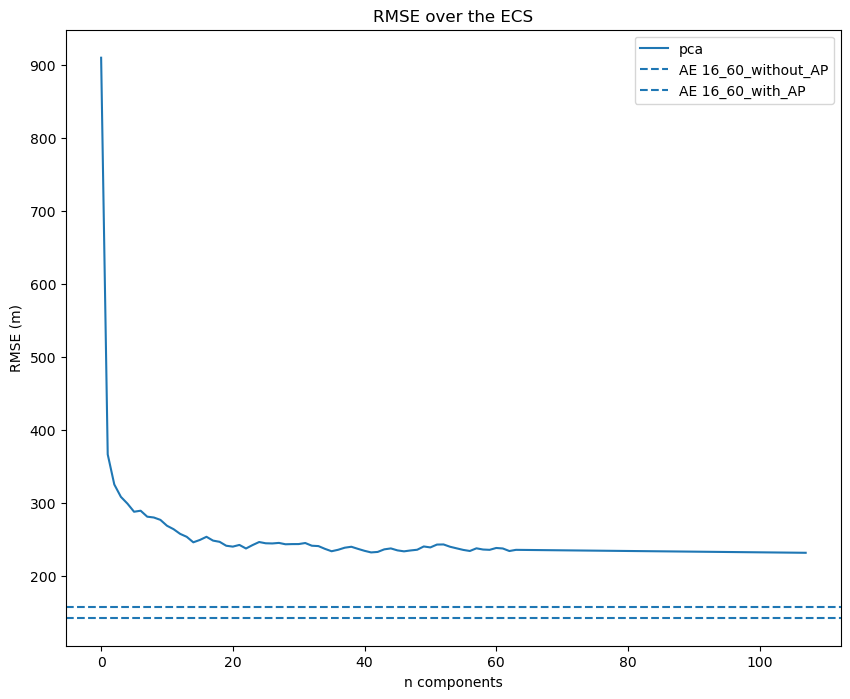

In [173]:
plt.figure(figsize=(10,8))

n_compo = list(rmse_dict.keys())
rmse_pca = list(rmse_dict.values())

# Plot the data
plt.plot(n_compo, rmse_pca,label='pca')

#Add a horizontal line at y=3
for arch_shape,ae_rmse in ecs_from_ae_rmse_dict.items():
    if '_'.join(arch_shape.split('_')[:-2]) in ['16_60']:
        plt.axhline(y=ae_rmse, linestyle='--', label=f'AE {arch_shape}')
# plt.axhline(y=ecs_from_ae_rmse_dict['16_60_without_AP'],c = 'r' ,linestyle='--', label=f'AE 16_60_without_AP')
# plt.axhline(y=ecs_from_ae_rmse_dict['16_60_with_AP'], c = 'g', linestyle='--', label=f'AE 16_60_with_AP')
# Add labels and title
plt.xlabel('n components')
plt.ylabel('RMSE (m)')
plt.title('RMSE over the ECS')

# Add legend
plt.legend()

# Show plot
plt.show()

Text(0.5, 0.95, 'Random celerity profiles')

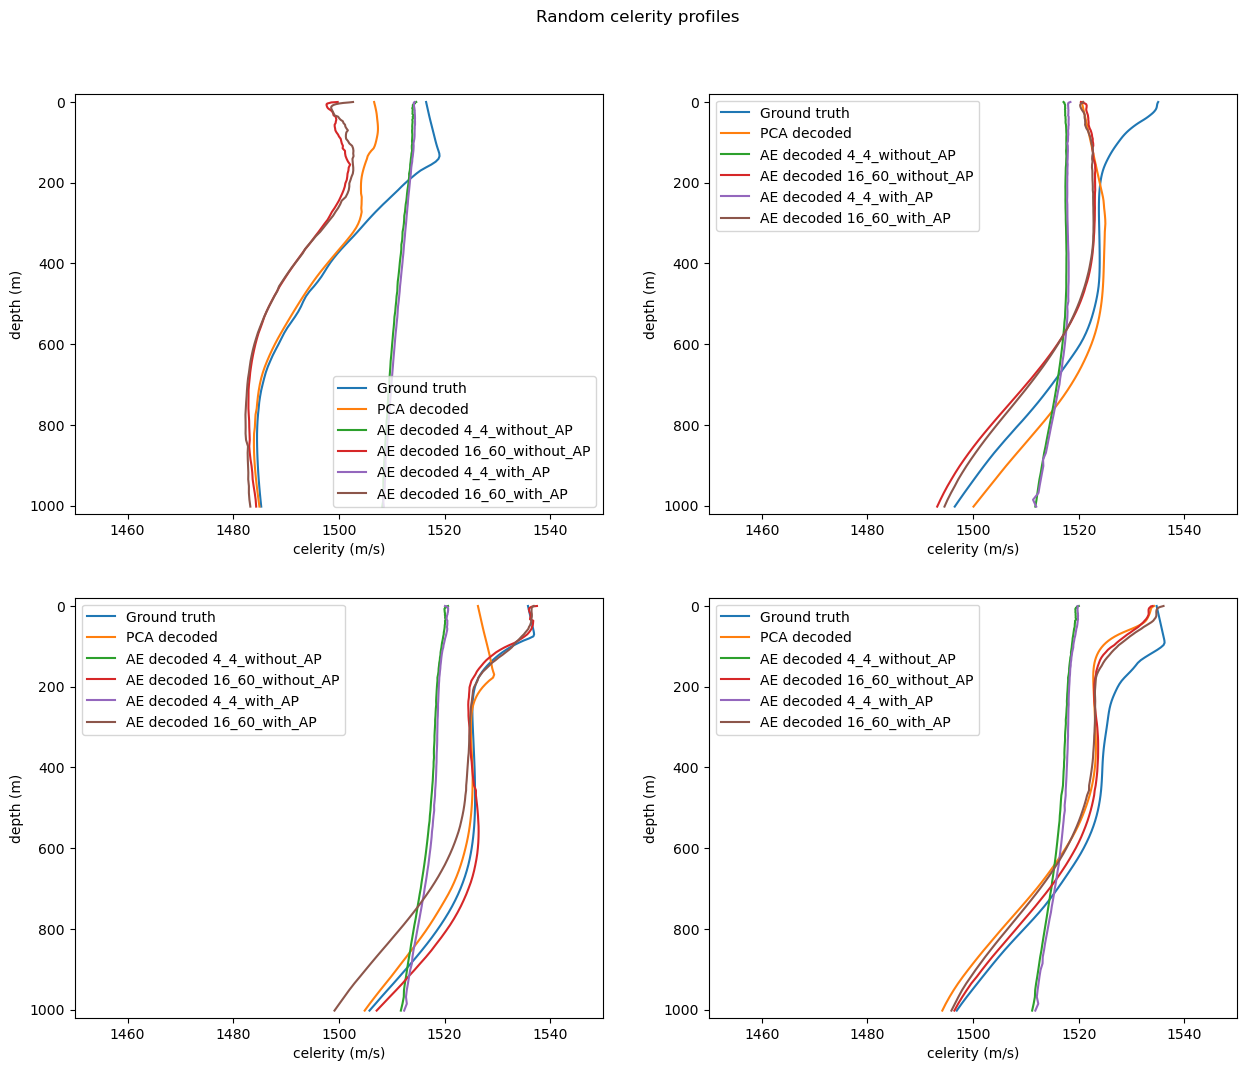

In [157]:
fig,axs = plt.subplots(2,2, figsize = (15,12))
for i,ax in enumerate(axs.flatten()):
    t,lat,lon = min_ss_std_idx[i]
    ax.plot(ss_da_test.isel(time = random_t_lat_lon[i][0], lat = random_t_lat_lon[i][1], lon = random_t_lat_lon[i][2]),coords['z'].values, label = 'Ground truth')
    ax.plot(output_test_decoded_pca[random_t_lat_lon[i][0],:,random_t_lat_lon[i][1],random_t_lat_lon[i][2]],coords['z'].values, label = 'PCA decoded')
    for arch_shape,output_ae_test in output_ae_test_dict.items():
        if '_'.join(arch_shape.split('_')[:-2]) in ['16_60','4_4']:
            ax.plot(output_ae_test[random_t_lat_lon[i][0],:,random_t_lat_lon[i][1],random_t_lat_lon[i][2]],coords['z'].values, label = f"AE decoded {arch_shape}")
    ax.set_ylim(y_min_axs, y_max_axs)  # Set y-axis limits
    ax.set_xlim(x_min_axs, x_max_axs)  # Set x-axis limits
    ax.invert_yaxis()
    ax.set_xlabel('celerity (m/s)')
    ax.set_ylabel('depth (m)')
    ax.legend()
title = "Random celerity profiles"
fig.suptitle(title, y = 0.95)